In [1]:
from tensorflow import __version__ as tf_version
from keras import __version__ as keras_version

print(f'keras_version=={keras_version}, tf_version=={tf_version}')

Using TensorFlow backend.


keras_version==2.2.0, tf_version==1.10.0


In [1]:
TOGGLE_REMOVEBG = True
# TOGGLE_REMOVEBG = False

In [2]:
import argparse
import csv
import os

from efficientnet import EfficientNetB3 as Net
from keras import Sequential, layers, optimizers
from numpy import argmax
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from IPython.display import Image
import matplotlib.pyplot as plt
# IPython magic command:
%matplotlib inline

Using TensorFlow backend.


In [3]:
BATCH_SIZE = 1024
WIDTH = 32
HEIGHT = 32
EPOCHS = 5
NUM_TRAIN = 8144
NUM_TEST = 7453
DROPOUT_RATE = 0.2
INPUT_SHAPE = (HEIGHT, WIDTH, 3)
NFROZEN_LAYERS = 390

names_list = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/names.csv'

In [4]:
def generate_dataset(remove_background: bool):
    global train_dir, validation_dir, test_dir
    train_dir = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data/train'
    validation_dir = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data/validation'
    test_dir = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data/test'
    if remove_background:
        train_dir = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data_removebg/train'
        validation_dir = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data_removebg/validation'
        test_dir = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data_removebg/test'

    train_datagen = ImageDataGenerator(rescale=1./255)
    global train_generator
    train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(HEIGHT, WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    validation_datagen = ImageDataGenerator(rescale=1./255)
    global validation_generator
    validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(HEIGHT, WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical')


def compile_model(h5_file: str, pretrained=False):
    conv_base = Net(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

    '''
    Set and print number of frozen layers of base efficientnet model.
    '''
    plot_model(conv_base, to_file='./output/conv_base.png', show_shapes=True)
    Image(filename='./output/conv_base.png')

    print(f'\nconv_base.layers length: {len(conv_base.layers)}')

    for layer in conv_base.layers[:NFROZEN_LAYERS]:
        layer.trainable = False

    trainable_layers = 0
    for layer in conv_base.layers:
        if layer.trainable:
            trainable_layers += 1

    print(f'Left last {trainable_layers} layers of conv_base trainable.')

    '''
    After these base layers are added to new Sequential(),
    they will be interpreted as a unit.
    '''
    global model
    model = Sequential()
    model.add(conv_base)
    model.add(layers.GlobalMaxPooling2D())
    if DROPOUT_RATE: model.add(layers.Dropout(DROPOUT_RATE))
    model.add(layers.Dense(196, activation="softmax"))

    print(f'model.layers length: {len(model.layers)}')

    if pretrained:
        model.load_weights(h5_file)
    else:
        '''
        Compile and train model.
        '''
        model.compile(loss='categorical_crossentropy',
#                       optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
                      optimizer=optimizers.RMSprop(lr=200, rho=0.9, epsilon=None, decay=0.0),
                      metrics=['accuracy'])
                    
                    

        plot_model(model, to_file='./output/model.png', show_shapes=True)
        Image(filename='./output/model.png')

        global history
        history = model.fit_generator(
            train_generator,
            steps_per_epoch= NUM_TRAIN //BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=validation_generator,
            validation_steps= NUM_TEST //BATCH_SIZE,
            verbose=1,
            use_multiprocessing=True,
            workers=4)

        os.makedirs("./models", exist_ok=True)
        model.save(h5_file)


def plot_epochs():
    ACC = history.history['acc']
    VAL_ACC = history.history['val_acc']
    LOSS = history.history['loss']
    VAL_LOSS = history.history['val_loss']
    EPOCHS_X = range(len(ACC))

    plt.plot(EPOCHS_X, ACC, 'bo', label='Training acc')
    plt.plot(EPOCHS_X, VAL_ACC, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(EPOCHS_X, LOSS, 'bo', label='Training loss')
    plt.plot(EPOCHS_X, VAL_LOSS, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def test_accuracy():
    def standard_path(astring) -> str:
        if astring.endswith('/'):
            return astring

        return astring+'/'


    def csv_to_dicts(filename) -> dict:
        class_dict = {}
        with open(filename, mode='r') as infile:
            reader = csv.reader(infile)
            class_index = 0
            for row in reader:
                class_dict[class_index] = row
                class_index += 1

        return class_dict


    def predict_image(image_path) -> list:
        img = image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)
        x /= 255.
        top1_index = argmax(model.predict([x])[0])
        class_dict = csv_to_dicts(names_list)
        verdict = class_dict[top1_index]
        
        return verdict[0]

    '''
    Run predict_image() folder by folder.
    '''
    print(f'Reading test_dir={test_dir}')
    correct = 0
    categories = os.listdir(test_dir)
    total = len(categories)
    assert total == 196

    for folder in categories:
        folder_path = standard_path(test_dir)+standard_path(folder)
        for image_file in os.listdir(folder_path):
            image_path = folder_path+image_file
            verdict = predict_image(image_path)
            
            if folder.lower() == verdict.lower():
                correct += 1                
            else:                
                print(f'Wrong: folder = {folder}, verdict = {verdict}')
    
    print(f'Test accuracy: {correct/total*100}% ({correct}/588)')

In [5]:
class Solution:
    def __init__(self, remove_background: bool):
        self.remove_background = remove_background
        
        if self.remove_background:
            self.h5_file = './models/efficientnet_stanford_car_removebg.h5'
        else:
            self.h5_file = './models/efficientnet_stanford_car.h5'

    def train_model(self):
        '''
        Plot model training and validation loss and accuracy
        '''
        generate_dataset(self.remove_background)
        compile_model(self.h5_file)


    def predict_cars(self):
        '''
        Load model from WEIGHTS_FILE then output test data accuracy
        '''
        compile_model(self.h5_file, pretrained=True)
        test_accuracy()

Found 8144 images belonging to 196 classes.
Found 7453 images belonging to 196 classes.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.

conv_base.layers length: 403
Left last 13 layers of conv_base trainable.
model.layers length: 4


/home/tbmreza/development/efficientnet_keras_transfer_learning/keras220_env/lib/python3.6/site-packages/keras/engine/training_generator.py:44: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
6/7 [========================>.....] - ETA: 14s - loss: 14.2955 - acc: 0.0049

/home/tbmreza/development/efficientnet_keras_transfer_learning/keras220_env/lib/python3.6/site-packages/keras/engine/training_generator.py:272: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


7/7 [==============================] - 179s 26s/step - loss: 14.5446 - acc: 0.0049 - val_loss: 16.0461 - val_acc: 0.0045
Epoch 2/5
7/7 [==============================] - 90s 13s/step - loss: 16.0349 - acc: 0.0052 - val_loss: 16.0439 - val_acc: 0.0046
Epoch 3/5
7/7 [==============================] - 89s 13s/step - loss: 16.0394 - acc: 0.0049 - val_loss: 16.0394 - val_acc: 0.0049
Epoch 4/5
7/7 [==============================] - 91s 13s/step - loss: 16.0459 - acc: 0.0045 - val_loss: 16.0394 - val_acc: 0.0049
Epoch 5/5
7/7 [==============================] - 90s 13s/step - loss: 16.0102 - acc: 0.0067 - val_loss: 16.0439 - val_acc: 0.0046


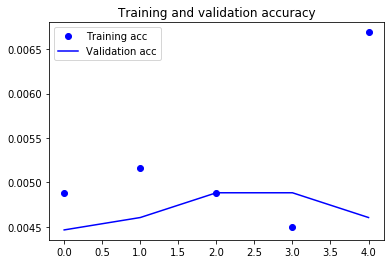

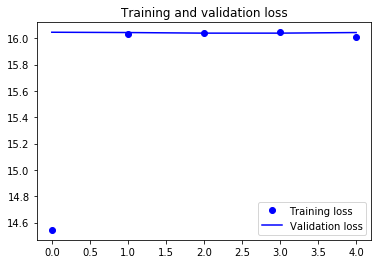

In [6]:
# def set_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--train', action='store_true',
#                         help='Plot model training and validation loss and accuracy')
#     parser.add_argument('--predict', action='store_true',
#                         help='Load model from WEIGHTS_FILE then output test data accuracy')                       
#     parser.add_argument('--removebg', action='store_true',
#                         help='Set image background removal preprocessing')
    
#     return parser.parse_args() 

# args = set_args()

'''
Simulate `python3 main.py --removebg --train --predict`
(or `python3 main.py --train --predict` if TOGGLE_REMOVEBG=False)
'''
class MockArgs:
    def __init__(self):
        self.removebg = TOGGLE_REMOVEBG
        self.train = True
        self.predict = True
    
args = MockArgs()

remove_background = False
if args.removebg:
    remove_background = True

run = Solution(remove_background)

if args.train:
    run.train_model()
    plot_epochs()

In [7]:
if args.predict:
    assert os.path.exists(run.h5_file)
    run.predict_cars()


conv_base.layers length: 403
Left last 13 layers of conv_base trainable.
model.layers length: 4
Reading test_dir=./dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data_removebg/test
Wrong: folder = Ford Mustang Convertible 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Ford Mustang Convertible 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Ford Mustang Convertible 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = BMW 1 Series Coupe 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = BMW 1 Series Coupe 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = BMW 1 Series Coupe 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Acura TSX Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Acura TSX Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Acura 

Wrong: folder = Hyundai Azera Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Hyundai Azera Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Hyundai Azera Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Rolls-Royce Phantom Drophead Coupe Convertible 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Rolls-Royce Phantom Drophead Coupe Convertible 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Rolls-Royce Phantom Drophead Coupe Convertible 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Audi 100 Sedan 1994, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Audi 100 Sedan 1994, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Audi 100 Sedan 1994, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Dodge Ram Pickup 3500 Quad Cab 2009, verdict = Chevrol

Wrong: folder = Hyundai Elantra Sedan 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Aston Martin V8 Vantage Convertible 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Aston Martin V8 Vantage Convertible 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Aston Martin V8 Vantage Convertible 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Suzuki Kizashi Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Suzuki Kizashi Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Suzuki Kizashi Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Suzuki SX4 Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Suzuki SX4 Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Suzuki SX4 Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2

Wrong: folder = Acura ZDX Hatchback 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Acura ZDX Hatchback 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Acura ZDX Hatchback 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Toyota Sequoia SUV 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Toyota Sequoia SUV 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Toyota Sequoia SUV 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Bugatti Veyron 16.4 Coupe 2009, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Bugatti Veyron 16.4 Coupe 2009, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Bugatti Veyron 16.4 Coupe 2009, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Ram C-V Cargo Van Minivan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Ram

Wrong: folder = Volvo C30 Hatchback 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Volvo C30 Hatchback 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Ford Focus Sedan 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Ford Focus Sedan 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Ford Focus Sedan 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = BMW M3 Coupe 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = BMW M3 Coupe 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = BMW M3 Coupe 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Dodge Dakota Club Cab 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Dodge Dakota Club Cab 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Dodge Dakota Club Cab 2007, verdict = Chevrolet Si

Wrong: folder = Hyundai Sonata Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Hyundai Sonata Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Hyundai Sonata Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Land Rover Range Rover SUV 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Land Rover Range Rover SUV 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Land Rover Range Rover SUV 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Dodge Challenger SRT8 2011, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Dodge Challenger SRT8 2011, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Dodge Challenger SRT8 2011, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Chrysler Town and Country Minivan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2

Wrong: folder = Chevrolet Silverado 1500 Classic Extended Cab 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Chevrolet Silverado 1500 Classic Extended Cab 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Mitsubishi Lancer Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Mitsubishi Lancer Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Mitsubishi Lancer Sedan 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = BMW 6 Series Convertible 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = BMW 6 Series Convertible 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = BMW 6 Series Convertible 2007, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Dodge Caliber Wagon 2012, verdict = Chevrolet Silverado 2500HD Regular Cab 2012
Wrong: folder = Dodge Caliber Wagon 2012, verdict = Chevr